In [ ]:
import matplotlib.pyplot as plt
import math
import numpy as np
import os
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    %matplotlib inline
else:
    %matplotlib widget

v = np.arange(-90,50,1)
temp = []
temp2 = []
for i in range(len(v)):
    sfunc = 1/(1+(0.33*math.exp(-0.06*v[i]))) #function from mod file same as Guoshi's paper
    #BB_sfunc = 1/(1+math.exp(0.07207477*-v[i])*(1/2.5522415)) #from ProbAMPA model
    #different_BB_sfunc = 1 / (1 + math.exp(0.062 * -(v[i])) * (1 / 3.57 )) # from DetAMPA model
    GluSynapse = 1 / (1 + math.exp(-0.072 *v[i]) * (1/2.552)) #from Glusynapse file
    temp.append(sfunc)
    temp2.append(GluSynapse)

plt.title("Mg block sfunc")
plt.plot(v,temp,label='guoshi')
plt.plot(v,temp2,label='blue brain')
plt.legend()
plt.xlabel('voltage (mv)')
plt.show()

if RunningInCOLAB:
    !pip install ipywidgets==7.7.1 &> /dev/null
    !pip install neuron==8.0.0 &> /dev/null
    !git clone https://github.com/GregGlickert/NMDA_single_cell.git &> /dev/null 
    %cd NMDA_single_cell
if(os.path.exists('x86_64')==False):
    os.system('nrnivmodl modfiles') # compile modfiles. Return 0 for success, 1 for failure.

BB stands for blue brain projects model


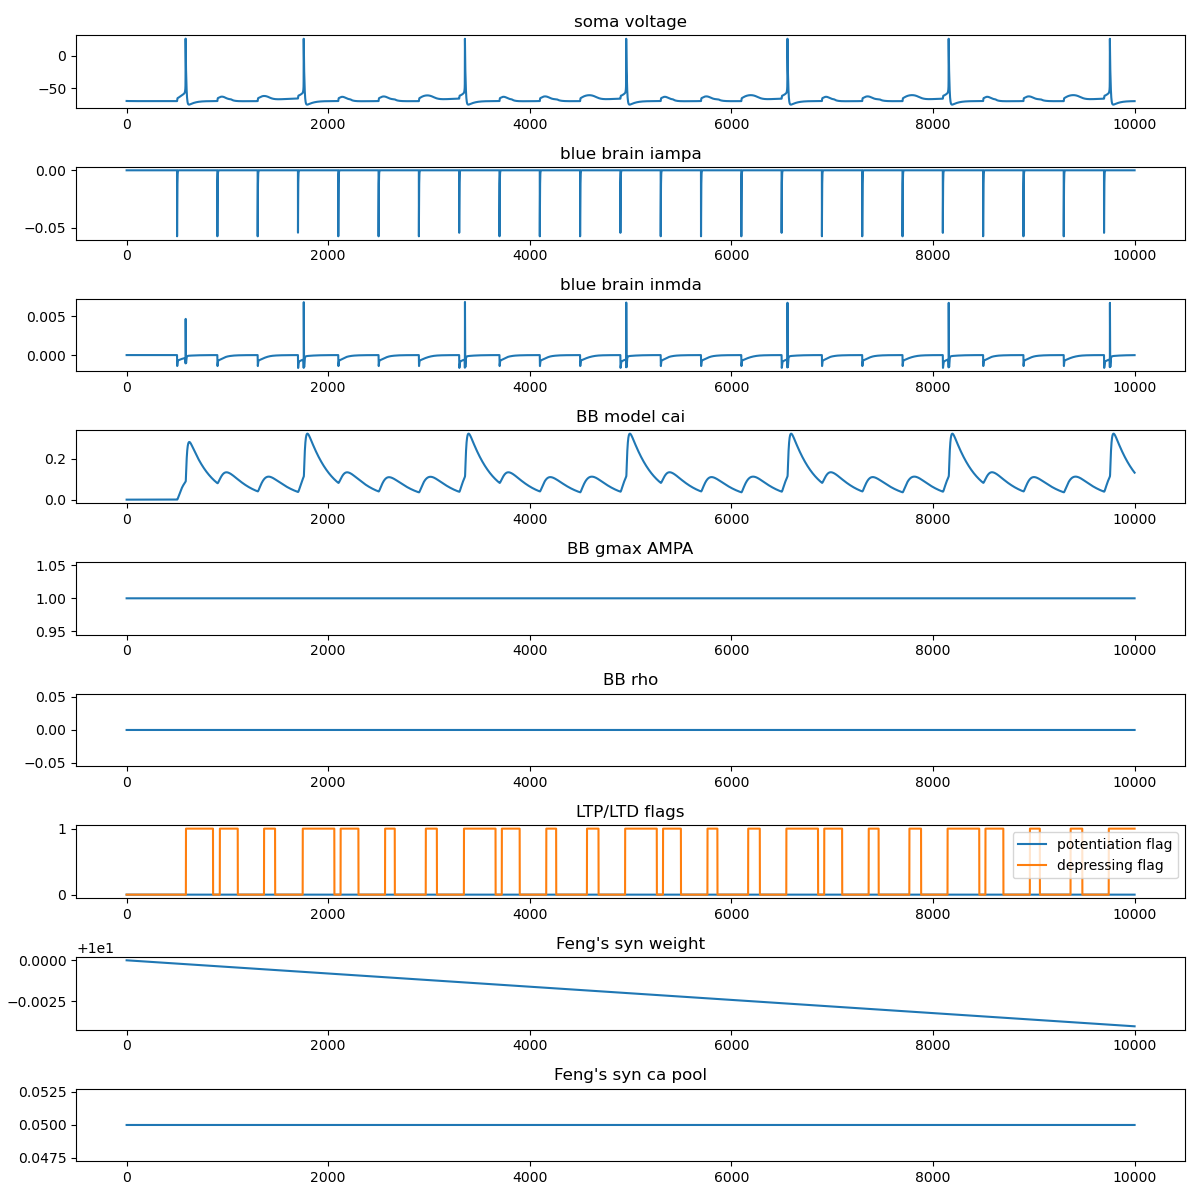

Blue brain weight 1.0
Feng's weight 9.995956277982506


In [ ]:
from neuron import h
from neuron.units import ms, mV
import matplotlib.pyplot as plt
from matplotlib import gridspec
import ipywidgets as widgets
from ipywidgets import interactive_output,HBox,VBox,Label,Layout
from IPython.display import display
from IPython.display import clear_output
import os
import numpy as np

RunningInCOLAB = 'google.colab' in str(get_ipython())

if RunningInCOLAB:
    %matplotlib inline
else:
    %matplotlib widget

def model(tstop,ourWeight,blueBrainWeight, fengFreqency,blueBrainFreqency,ourStart,blueBrainStart,bb_threshold1,bb_threshold2,tau_ind_GB,rho0_GB,feng_threshold1,feng_threshold2):
    h.load_file('stdrun.hoc')
    h.load_file('PN_cells.hoc') # reads in template
    #h.nrn_load_dll('x86_64/.libs/libnrnmech.so')
    cell = h.PN_C()
    #cell = h.InterneuronCellf()
    h.dt = 0.1 # time step (resolution) of the simulation in ms
    h.tstop = tstop # how long to run the simulation in ms
    h.v_init= -70 # initial membrane potential in mV

    t = h.Vector()      # Vectors are used to record data in the simulation
    soma_v = h.Vector()
    W = h.Vector()
    g_nmda = h.Vector()
    g_ampa = h.Vector()
    v_syn = h.Vector() # cant record i_nmda or i_ampa but can record these and put it together my self
    cai = h.Vector()
    gmax_ampa = h.Vector()
    rho_GB = h.Vector()
    dep_GB = h.Vector()
    pot_GB = h.Vector()
    capoolcon = h.Vector()

    conn1 = h.pyr2pyr(cell.dend[0](0.9)) # makes a syn connected to soma

    t.record(h._ref_t) # derefences and records data
    soma_v.record(cell.soma[0](0.5)._ref_v)
    W.record(conn1._ref_W)
    capoolcon.record(conn1._ref_capoolcon)
    #i_ampa_1.record(conn1._ref_iampa)


    #iclamp = h.IClamp(cell.dend[0](0.5)) # current injection
    #iclamp.delay = 10050 #long enought delay turns off iclamp easy
    #iclamp.dur = 200
    #iclamp.amp = 0.3

    conn1.initW = ourWeight #synaptic weight for pyr2pyr(our synapse)
    conn1.threshold1 = feng_threshold1
    conn1.threshold2 = feng_threshold2
    nstim_pyr2pyr= h.NetStim(0.9)

    nstim_pyr2pyr.interval=1000/fengFreqency #pyrpyr synapse 
    nstim_pyr2pyr.start=ourStart
    nstim_pyr2pyr.number = 100
    nstim_pyr2pyr.noise = 0 
    nc_pyr2pyr = h.NetCon(nstim_pyr2pyr,conn1,0,0,1)

    conn2 = h.AMPA_NMDA_STP_LTP_tone2PN(cell.dend[0](0.9)) #blue brain project synapse 

    conn2.initW = blueBrainWeight
    t.record(h._ref_t) # derefences and records data
    g_nmda.record(conn2._ref_g_NMDA)
    g_ampa.record(conn2._ref_g_AMPA)
    v_syn.record(conn2._ref_vsyn)
    cai.record(conn2._ref_effcai_GB)
    gmax_ampa.record(conn2._ref_gmax_AMPA)
    rho_GB.record(conn2._ref_rho_GB)
    pot_GB.record(conn2._ref_pot_GB)
    dep_GB.record(conn2._ref_dep_GB)

    conn2.gmax0_AMPA = 1
    conn2.theta_d_GB = bb_threshold1
    conn2.theta_p_GB = bb_threshold2

    conn2.temp_tau = tau_ind_GB
    #conn2.temp_rho0 = rho0_GB

    #conn.weight = 0.001 #synaptic weight
    nstim_GluSynapse= h.NetStim(0.9)

    nstim_GluSynapse.interval=1000/blueBrainFreqency #blue brain project synapse 
    nstim_GluSynapse.start=blueBrainStart
    nstim_GluSynapse.number = 100
    nstim_GluSynapse.noise = 0 
    nc_GluSynapse = h.NetCon(nstim_GluSynapse,conn2,0,0,1) #change this number to change syn weight currently it 1 

    h.finitialize(h.v_init * mV)
    h.continuerun(h.tstop * ms)
    
    plot(t,soma_v,g_ampa,g_nmda,v_syn,cai,gmax_ampa,rho_GB,pot_GB,dep_GB,W,capoolcon)

def plot(t,soma_v,g_ampa,g_nmda,v_syn,cai,gmax_ampa,rho_GB,pot_GB,dep_GB,W,capoolcon):
    fig = plt.figure(figsize=(12, 12),tight_layout=True) 
    gs = gridspec.GridSpec(9, 1, width_ratios=[1],height_ratios=[1,1,1,1,1,1,1,1,1]) 

    i_ampa_blueBrain = g_ampa * (v_syn-0) #manually getting iampa/nmda
    i_nmda_blueBrain = g_nmda * (v_syn-(-3))

    ax0 = plt.subplot(gs[0,0])
    ax1 = plt.subplot(gs[1,0])
    ax2 = plt.subplot(gs[2,0])
    ax3 = plt.subplot(gs[3,0])
    ax4 = plt.subplot(gs[4,0])
    ax5 = plt.subplot(gs[5,0])
    ax6 = plt.subplot(gs[6,0])
    ax7 = plt.subplot(gs[7,0])
    ax8 = plt.subplot(gs[8,0])

    ax0.plot(t ,soma_v)
    ax0.set_title('soma voltage')

    ax1.plot(t,i_ampa_blueBrain)
    ax1.set_title('blue brain iampa')

    ax2.set_title('blue brain inmda')
    ax2.plot(t,i_nmda_blueBrain)

    ax3.plot(t,cai)
    ax3.set_title('BB model cai')

    ax4.plot(t, gmax_ampa)
    ax4.set_title('BB gmax AMPA')

    ax5.plot(t ,rho_GB)
    ax5.set_title('BB rho')

    ax6.plot(t ,pot_GB,label='potentiation flag')
    ax6.plot(t, dep_GB,label='depressing flag')
    ax6.set_title('LTP/LTD flags')

    ax7.plot(t,W)
    ax7.set_title("Feng's syn weight")

    capoolcon = capoolcon.as_numpy()
    capoolcon[:] = [x * 1000 for x in capoolcon]
    ax8.plot(t,capoolcon)
    ax8.set_title("Feng's syn ca pool")

    ax6.legend()
    plt.show()
    print("Blue brain weight",gmax_ampa[-1])
    print("Feng's weight", W[-1])


tstop = 2500
ourWeight = 10
feng_threshold1 = 0.3
feng_threshold2 = 0.4
blueBrainWeight = 10
ourStart = 1700
blueBrainStart = 500
blueBrainFreqency = 0.001
fengFreqency = 0.001
bb_threshold1 = 0.1
bb_threshold2 = 0.28
rho0_GB = 0
tau_ind_GB = 70

w_run = widgets.Button(description='Run',icon='history',button_style='primary')
w_tstop = widgets.FloatSlider(value=tstop,min=100,max=10000, step=100,description='Tstop (ms)')
w_ourWeight = widgets.FloatSlider(value=ourWeight,min=0,max=300, step=0.5,description='feng Weight')
w_blueBrainWeight = widgets.FloatSlider(value=blueBrainWeight,min=0,max=300, step=0.5,description='BB Weight')
w_blueBrainFreqency = widgets.FloatSlider(value=blueBrainFreqency,min=0.001,max=300, step=0.5,description='BB Freq')
w_fengFreqency = widgets.FloatSlider(value=fengFreqency,min=0.001,max=300, step=0.5,description='feng Freq')
w_ourStart = widgets.FloatSlider(value=ourStart,min=100,max=20000, step=100,description='feng Start')
w_blueBrainStart = widgets.FloatSlider(value=blueBrainStart,min=100,max=20000, step=10,description='BB Start')
w_bb_threshold1 = widgets.FloatSlider(value=bb_threshold1,min=0.01,max=2, step=0.01,description='BB Thres1')
w_bb_threshold2 = widgets.FloatSlider(value=bb_threshold2,min=0.01,max=2, step=0.01,description='BB Thres2')
w_feng_threshold1 = widgets.FloatSlider(value=feng_threshold1,min=0.01,max=2, step=0.01,description='Feng Thres1')
w_feng_threshold2 = widgets.FloatSlider(value=feng_threshold2,min=0.01,max=2, step=0.01,description='Feng Thres2')
w_tau_ind_GB = widgets.FloatSlider(value=tau_ind_GB,min=0,max=200, step=0.1,description='tau_ind_GB')
w_rho0_GB = widgets.FloatSlider(value=rho0_GB,min=-1,max=1, step=1,description='rho0_GB')

print("BB stands for blue brain projects model")
def run_model(*arges):
    clear_output()
    tstop = w_tstop.value
    feng_threshold1 = w_feng_threshold1.value
    feng_threshold2 = w_feng_threshold2.value
    bb_threshold1 = w_bb_threshold1.value
    bb_threshold2 = w_bb_threshold2.value
    rho0_GB = w_rho0_GB.value
    tau_ind_GB = w_tau_ind_GB.value
    blueBrainWeight = w_blueBrainWeight.value
    ourWeight = w_ourWeight.value
    fengFreqency = w_fengFreqency.value
    blueBrainFreqency = w_blueBrainFreqency.value
    ourStart = w_ourStart.value
    blueBrainStart = w_blueBrainStart.value
    print("BB stands for blue brain projects model")
    display(ui)
    model(tstop,ourWeight,blueBrainWeight, fengFreqency,blueBrainFreqency,ourStart,blueBrainStart,bb_threshold1,bb_threshold2,tau_ind_GB,rho0_GB,feng_threshold1, feng_threshold2)
    
w_run.on_click(run_model)

ui = VBox([ HBox([w_run,w_tstop]), HBox([w_ourWeight,w_blueBrainWeight,w_bb_threshold1,w_feng_threshold1]), HBox([w_fengFreqency,w_blueBrainFreqency,w_bb_threshold2,w_feng_threshold2]),HBox([w_ourStart,w_blueBrainStart,w_tau_ind_GB])])
ui
    

In [ ]:
1.3619349853110971